In [2]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Schematics
Copied from code used for [paper](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/generate_all_paper_figs.ipynb).

Make schematics to illustrate physical mechanisms, with an approximate moist lapse rate following exponential decay with temperature.

In figures, dashed lines indicate current climate. Dotted lines are if warm at FT with no lapse rate change. Black lines indicate day with no CAPE in current climate and no RH or CAPE change with warming. Red lines indicate change according to mechanism under consideration, which results in amplified warming. Dotted blue lines indicate moist adiabatic profile given surface conditions.

In [4]:
labels_cont = {'temp_ft_change': 'FT change', 'rh_change': 'RH change', 'sCAPE_change': 'CAPE change',
               'temp_surf_anom': 'Hot-get-hotter', 'rh_anom': 'Drier-get-hotter', 'lapse_D_change': '$\eta_D$ change',
               'lapse_M_change': '$\eta_M$ change', 'lapse_D_anom': '$\eta_D$ climatological'}
leg_handlelength = 1.5

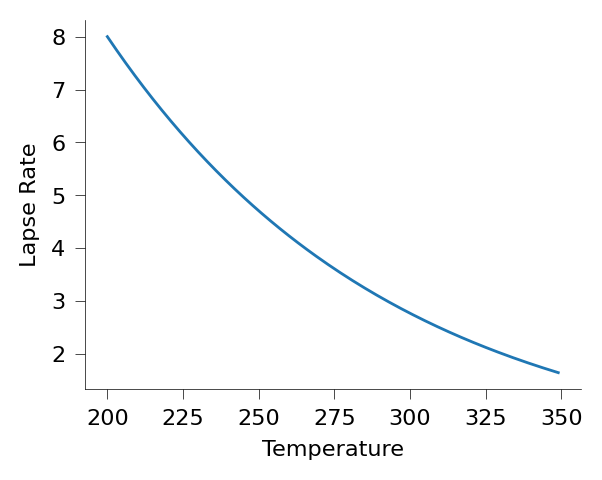

In [5]:
# Define approximate moist lapse rate to follow exponential decay function, so near dry adiabat at low temperatures and moist adiabat at high temp
def moist_lapse_exp_decay(x, dry_lapse=10, temp_dry=200, temp0=350, decay_sigma=10):
    # Define approximate moist lapse rate to follow exponential decay function, so equal 0.8*dry lapse rate at temp_dry, and nearly zero at temp0.
    # Decay_sigma controlls the rate of the decay with temperature, smaller means more rapid decay
    # Given conditions
    x_start, x_end = temp_dry, temp0
    y_start, y_end = 0.8 * dry_lapse, 1e-6  # Assume nearly zero at x=300

    # Solve for decay rate k
    k = np.log(y_start / y_end) / (x_end - x_start)
    return y_start * np.exp(-k * (x - x_start) / decay_sigma)


fig, ax = plt.subplots(1, 1)
fig_resize(fig, width['one_col'])
ax.plot(np.arange(200, 350), moist_lapse_exp_decay(np.arange(200, 350), 10))
ax.set_xlabel('Temperature')
ax.set_ylabel('Lapse Rate')
update_fontsize(fig)
update_linewidth(fig)
plt.show()

In [6]:
schem_info = {'lapse_dry': 10,
              'lapse_moist': moist_lapse_exp_decay,
              'height': np.linspace(0, 10, 1000),
              # moist lapse rate decreases from lapse dry to 0, between 200K and 300K
              'temp_ft0': 240,
              'lcl0': 3,
              'lcl_large': 7,
              'temp_ft_change': 50,
              'temp_anom': 85,
              'color_mech': 'C3',
              'color_cape': 'C3',
              'linestyle_cape': '-.',
              'dash_cape': [10, 4, 1, 5],  # Dash, Gap, Dot, Gap
              'lapse_moist_change': 4,
              'lapse_dry_change': 10,
              'lapse_dry_anom': -6,
              }


def get_schem_profile(temp_ft=schem_info['temp_ft0'], lcl=schem_info['lcl0'], height=schem_info['height'],
                      lapse_moist_mod=0,
                      lapse_dry_mod=0):
    # Lapse_moist_mod is epsilon or CAPE, larger means more CAPE i.e. lapse rate further from moist, closer to dry adiabat
    temp_profile = np.zeros_like(height)
    temp_profile[height >= lcl] = temp_ft + (schem_info['lapse_moist'](temp_ft) + lapse_moist_mod) * (
            height[-1] - height[height >= lcl])
    lcl_ind = np.where(height >= lcl)[0][0]
    temp_profile[height < lcl] = temp_profile[lcl_ind] + (schem_info['lapse_dry'] + lapse_dry_mod) * (
            height[lcl_ind] - height[height < lcl])
    return temp_profile


def get_schem_profile_from_surf(temp_surf, lcl=schem_info['lcl0'], height=schem_info['height'], lapse_moist_mod=0,
                                lapse_dry_mod=0):
    def func_to_minimize(x):
        # Find surface temperature of profile given x as temp_ft
        # Return difference between this and desired temp_surf
        return np.abs(get_schem_profile(x, lcl, height, lapse_moist_mod, lapse_dry_mod)[0] - temp_surf)

    # First find ft temperature that gives the surface temperature
    temp_ft_use = scipy.optimize.minimize_scalar(func_to_minimize, bounds=(200, 380), method="bounded").x
    return get_schem_profile(temp_ft_use, lcl, height, lapse_moist_mod, lapse_dry_mod)


schem_info['temp_s0'] = get_schem_profile()[0]  # surface temperature in reference climate

In [7]:
def move_axis_to_center(ax):
    # Get positions of original left and right bottom subplots
    pos_left = ax[1, 0].get_position()
    pos_right = ax[1, 1].get_position()  # any other plot in same column to get width

    # Compute center of the row
    row_center = (pos_left.x0 + pos_right.x0 + pos_right.width) / 2
    new_x0 = row_center - pos_left.width / 2

    # Move the bottom-left subplot to row center
    ax[1, 0].set_position([new_x0, pos_left.y0, pos_left.width, pos_left.height])

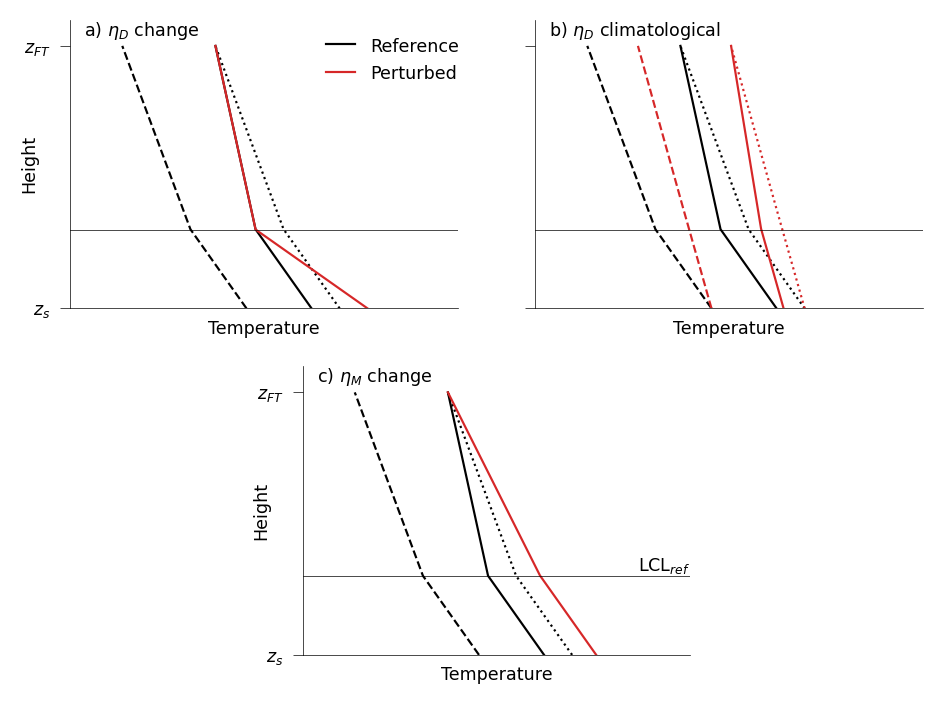

In [8]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
ax[1, 1].remove()
move_axis_to_center(ax)

# Plot change along moist adiabat in all figures
for i, ax_use in enumerate(ax.flatten()):
    ax_use.plot(get_schem_profile(), schem_info['height'], color='k', linestyle='--')
    ax_use.plot(get_schem_profile() + schem_info['temp_ft_change'], schem_info['height'], color='k', linestyle=':')
    # Remove axis info
    ax_use.plot(get_schem_profile(schem_info['temp_ft0'] + schem_info['temp_ft_change']), schem_info['height'],
                color='k', label='Reference')
    ax_use.set_xticks([])
    ax_use.set_yticks([0, 10], ['$z_s$', '$z_{FT}$'])
    ax_use.set_xlabel('Temperature')
    # ax_use.tick_params(axis='both', which='both', length=0)
    # ax_use.set_xticklabels([])
    # ax_use.set_yticklabels([])

# lapse_D Change
ax[0, 0].plot(get_schem_profile(schem_info['temp_ft0'] + schem_info['temp_ft_change'],
                                lapse_dry_mod=schem_info['lapse_dry_change']),
              schem_info['height'], color=schem_info['color_mech'],
              label='Perturbed')

# lapse_D climatological
schem_profile0 = get_schem_profile_from_surf(schem_info['temp_s0'], lapse_dry_mod=schem_info['lapse_dry_anom'])
ax[0, 1].plot(schem_profile0, schem_info['height'], color=schem_info['color_mech'], linestyle='--')
ax[0, 1].plot(
    get_schem_profile(schem_profile0[-1] + schem_info['temp_ft_change'], lapse_dry_mod=schem_info['lapse_dry_anom']),
    schem_info['height'], color=schem_info['color_mech'])
ax[0, 1].plot(schem_profile0 + schem_info['temp_ft_change'], schem_info['height'],
              color=schem_info['color_mech'], linestyle=':')

# lapse_M Change
ax[1, 0].plot(get_schem_profile(schem_info['temp_ft0'] + schem_info['temp_ft_change'],
                                lapse_moist_mod=schem_info['lapse_moist_change']),
              schem_info['height'], color=schem_info['color_mech'],
              label='Perturbed')

ax[0, 0].get_xlim()
ax[0, 0].set_xlim(212, 420)
ax[0, 0].set_ylim(0, schem_info['height'][-1] + 1)
for i in range(2):
    ax[i, 0].set_ylabel('Height', labelpad=-5)

# Put titles in letter labels to avoid looking like x axis labels
letter_order = ['a', 'c', 'b']
label_subplots(fig, ax.transpose().flatten()[:-1], [f"{letter_order[i]}) " + labels_cont[key] for i, key in
                                                    enumerate(['lapse_D_change', 'lapse_M_change', 'lapse_D_anom'])],
               box_alpha=0, pos_y=0)

ax[1, 0].text(ax[1, 0].get_xlim()[1], schem_info['lcl0'], "LCL$_{ref}$", color='k', va='bottom', ha='right')
# ax.text(100, -0.05, "Lapse Rate", color='k', va='top', ha='right')

update_linewidth(fig)
ax[0, 0].legend(loc='upper right', bbox_to_anchor=(1.05, 1), handlelength=leg_handlelength)
update_fontsize(fig)

for ax_use in ax.flatten():
    ax_use.axhline(schem_info['lcl0'], color='k', lw=ax_linewidth)
#plt.subplots_adjust(wspace=0.08)            # move axis closer together
plt.show()
# savefig(fig)

## Sensitivity Parameters
Here I plot the sensitivity parameters for the lapse rate mechanisms without any normalization, copied from code used to create figures for [paper](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/generate_all_paper_figs.ipynb).

In [9]:
n_temp_gamma_plot = 81
n_rh_gamma_plot = 101
temp_gamma_plot = np.linspace(285, 333, n_temp_gamma_plot)
rh_gamma_plot = np.linspace(0.2, 0.8, n_rh_gamma_plot)
gamma = {key: np.zeros((n_temp_gamma_plot, n_rh_gamma_plot)) for key in
         ['lapse_D_change', 'lapse_M_change', 'lapse_D_anom']}

for i in range(n_temp_gamma_plot):
    for j in range(n_rh_gamma_plot):
        var = get_sensitivity_factors(temp_gamma_plot[i], rh_gamma_plot[j], pressure_surf=1000 * 100,
                                      pressure_ft=500 * 100, temp_surf_lcl_calc=300)
        for key in gamma:
            gamma[key][i, j] = var[key]

In [10]:
gamma_plot_levels = {'lapse_D_change': np.asarray([0.08, 0.16, 0.24, 0.32]),
                     'lapse_M_change': np.asarray([0.3, 0.35, 0.4, 0.45, 0.5]),
                     'lapse_D_anom': {'pos': np.asarray([0.001, 0.002, 0.003]),
                                      'neg': np.asarray([-0.003, -0.001])}
                     }
gamma_plot_labels = {'lapse_D_change': '$\gamma_{\delta \eta_D}$ [KK$^{-1}$]',
                     'lapse_M_change': '$\gamma_{\delta \eta_M}$ [K%$^{-1}$]',
                     'lapse_D_anom': '$\gamma_{\Delta \eta_D}/\overline{T}_s$ [K$^{-1}$]'}
# Make sure gamma prefactor has RH in units of % when dividing
gamma_prefactor = {'lapse_D_change': 1, 'lapse_M_change': 1,
                   'lapse_D_anom': 1 / temp_gamma_plot[:, np.newaxis]}
# Manually position each contour label so does not overlap with title
clabel_pos = {'lapse_D_change': [(72, 310), (50, 310), (40, 310), (0, 310)],
              'lapse_M_change': [(20, 305), (35, 305), (50, 310), (55, 314), (60, 320), (70, 280)],
              'lapse_D_anom': {'pos': [(75, 320), (50, 320), (30, 320)],
                               'neg': [(28, 300), (28, 290)]}
              }

lw_contour = 0.2
fontsize_contour = 5

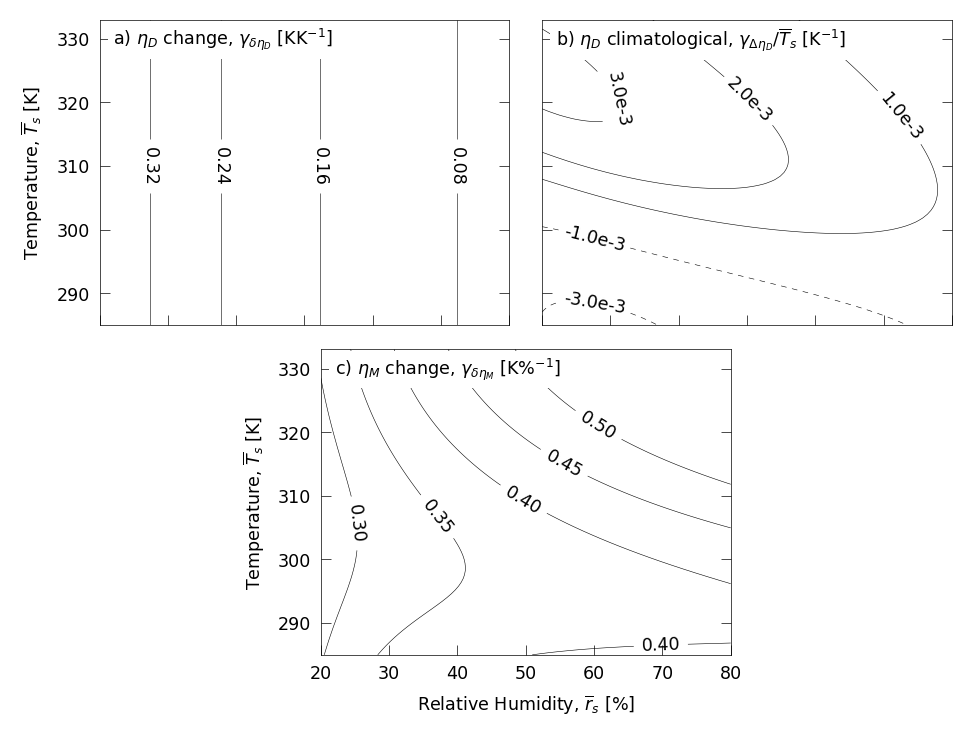

In [11]:
import matplotlib.ticker as ticker


def sci_no_leading_zero(x, _, n_decimal=None):
    if n_decimal == 1:
        return f"{x:.1e}".replace("e+0", "e").replace("e+", "e").replace("e0", "e0").replace("e-0", "e-")
    elif n_decimal is None:
        return f"{x:.0e}".replace("e+0", "e").replace("e+", "e").replace("e0", "e0").replace("e-0", "e-")


# fmt = ticker.FuncFormatter(lambda x, _: f"{x:.1e}")
fmt_no_decimal = ticker.FuncFormatter(lambda x, _: sci_no_leading_zero(x, _, None))
fmt_decimal = ticker.FuncFormatter(lambda x, _: sci_no_leading_zero(x, _, 1))
fmt = {'lapse_D_change': None, 'lapse_M_change': None, 'lapse_D_anom': fmt_decimal, 'r_anom': fmt_no_decimal}

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
ax[1, 1].remove()
ax_array = ax           # so can move to center later
ax = ax.transpose().flatten()
keys_plot = [key for key in gamma_plot_levels if ('cape' not in key)]
for j, key in enumerate(keys_plot):
    if j < int(np.ceil(len(ax) / 2)):
        ax[j].set_ylabel('Temperature, $\overline{T}_s$ [K]')
    # ax[j].set_title(labels_cont[key]+', '+gamma_plot_labels[key])
    ax[j].spines['right'].set_visible(True)
    ax[j].spines['top'].set_visible(True)
    # ax[j].xaxis.set_ticks_position('both')
    ax[j].yaxis.set_ticks_position('both')
    ax[j].tick_params(axis='both', direction='in')

    var = gamma[key] * gamma_prefactor[key]
    if isinstance(gamma_plot_levels[key], dict):
        var_plot = ax[j].contour(rh_gamma_plot * 100, temp_gamma_plot, np.where(var < 0, np.nan, var),
                                 levels=gamma_plot_levels[key]['pos'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key]['pos'])
        var_plot = ax[j].contour(rh_gamma_plot * 100, temp_gamma_plot, np.where(var > 0, np.nan, var),
                                 levels=gamma_plot_levels[key]['neg'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key]['neg'])
        for collection in var_plot.collections:
            # For negative values, increase dash separation, to emphasize negative
            collection.set_linestyle('--')  # Dotted line style
            collection.set_dashes([(0, (10.0, 10.0))])
    else:
        var_plot = ax[j].contour(rh_gamma_plot * 100, temp_gamma_plot, var,
                                 levels=gamma_plot_levels[key], colors='black', linewidths=lw_contour)
        clabels = ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key])

ax[-3].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
# Put titles in letter labels to avoid looking like x axis labels
letter_order = ['a', 'c', 'b']
label_subplots(fig, ax[:-1],
               [f"{letter_order[i]}) " + labels_cont[key] + ', ' + gamma_plot_labels[key] for i, key in
                enumerate(keys_plot)],
               box_alpha=1, pos_y=-2.5)


update_fontsize(fig)
# update_linewidth(fig)
plt.subplots_adjust(wspace=0.08, hspace=0.08)
move_axis_to_center(ax_array)
# savefig()

## Load data and average over `sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [12]:
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds, get_P

ds = get_ds(['aquaplanet'], dailymax=False)['aquaplanet']
p_ft = ds.p_ft
temp_surf_lcl_calc = ds.temp_surf_lcl_calc

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds['lapse_Dz'] = ds.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_Mz'] = ds.modParc1_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']

In [15]:
def get_p_lzb(ds):
    # Returns lzb pressure in Pa from the kzlbs model index
    P = get_P(ds)
    k = ds.klzbs - 1        # Offset by -1 because fortran starts with 1, but python starts with 0

    # map fractional index k -> physical lev coordinate
    i = xr.DataArray(
        np.arange(ds.lev.size),
        dims=("lev",),
        coords={"lev": ds.lev},
    )

    lev_k = xr.apply_ufunc(
        np.interp,
        k,              # x: fractional index
        i,              # xp: integer indices 0..n_lev-1
        ds.lev,            # fp: lev values
        input_core_dims=[[], ['lev'], ['lev']],
        output_core_dims=[[]],
        vectorize=True,
    )

    # now do the "fractional isel" via interp along lev
    return P.interp(lev=lev_k)
# LZB function requires sample as a coordinate not dimension
if 'sample' not in ds.coords:
    ds = ds.assign_coords(sample=("sample", np.arange(ds.sizes["sample"])))
ds['p_lzb'] = get_p_lzb(ds)

In [16]:
def get_ds_quant_and_ref(ds, error_thresh=0.25):
    # Take average over all days for which error satisfies convective threshold
    const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
    mod_parcel1_error = np.abs(ds.modParc1_error.sum(dim='layer') / ds.modParc1_integral.sum(dim='layer'))
    mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)# & (ds['p_lzb']/100 < 500)

    # Get rid of variables don't need anymore - those with lev and layer dimensions
    ds = ds.drop_dims(['lev', 'layer'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['sample', 'quant'])  # reference average over all convective days
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_M']].where(mask_fit).std(dim='sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref
    # ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall


ds_quant, ds_ref = get_ds_quant_and_ref(ds)

In [17]:
# Load in daily max as well for comparison later
ds_quant_daily_max = get_ds(['aquaplanet'], dailymax=True)['aquaplanet']

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds_quant_daily_max['lapse_Dz'] = ds_quant_daily_max.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_quant_daily_max['lapse_Mz'] = ds_quant_daily_max.modParc1_lapse.isel(layer=1) / 1000
ds_quant_daily_max['lapse_D'] = R / g * ds_quant_daily_max.TREFHT * ds_quant_daily_max['lapse_Dz']
ds_quant_daily_max['lapse_M'] = R / g * ds_quant_daily_max.T_ft_env * ds_quant_daily_max['lapse_Mz']
ds_quant_daily_max, ds_ref_daily_max = get_ds_quant_and_ref(ds_quant_daily_max)

KeyboardInterrupt: 

In [33]:
# Compute sCAPE from averaged quantities as takes too long to compute for each individual day
# Use parcel_def_include_z_approx=False because in this version of parcel definition, we get rid of A_z term
ds_quant['mse_REFHT'] = moist_static_energy(ds_quant.TREFHT, ds_quant.QREFHT, ds_quant.ZREFHT)
ds_quant['mse_ft_sat'] = moist_static_energy(ds_quant.T_ft_env, sphum_sat(ds_quant.T_ft_env, p_ft), ds_quant.Z_ft_env)
ds_quant['epsilon'] = ds_quant['mse_REFHT'] - ds_quant['mse_ft_sat']
get_cape_func = wrap_with_apply_ufunc(get_cape_approx, output_core_dims=[[], []])
ds_quant['sCAPE'] = get_cape_func(ds_quant.TREFHT, ds_quant.rh_REFHT, ds_quant.PREFHT, p_ft, ds_quant.T_ft_env,
                                  ds_quant.epsilon, parcel_def_include_z_approx=False)[0] * 1000

In [34]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

ds_quant = ds_quant.transpose('tau_lw', 'quant', 'lat')
ds_ref = ds_ref.transpose('tau_lw', 'lat')

In [35]:
lat_weights = np.cos(np.deg2rad(ds.lat))
percentile_label = 'Temperature Percentile, $x$'

## Scaling factor
I first get the scaling factor both numerically and normal linear theory, making the function work with xarray.

In [36]:
def apply_scale_factor_numerical(ds_quant, ds_ref, p_ft=p_ft, lapse_coords='lnp', sCAPE_form=False):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_nl, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical2,
        ds_ref["TREFHT"],  # (tau_lw)
        ds_quant["TREFHT"],  # (tau_lw, quant)
        ds_ref["rh_REFHT"].isel(tau_lw=0),
        ds_quant["rh_REFHT"],  # (tau_lw, quant)
        ds_quant["T_ft_env"],  # (tau_lw, quant)
        p_ft,  # (tau_lw) or scalar
        ds_ref["PREFHT"].isel(tau_lw=0),  # scalar
        ds_quant["PREFHT"],  # (tau_lw, quant) or None
        ds_quant[f"lapse_D{'z' if lapse_coords == 'z' else ''}"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant[f"lapse_M{'z' if lapse_coords == 'z' else ''}"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant['sCAPE'] if sCAPE_form else None,
        kwargs=dict(
            temp_surf_lcl_calc=temp_surf_lcl_calc,
            lapse_coords=lapse_coords
        ),
        input_core_dims=[
            ["tau_lw"],  # temp_surf_ref
            ["tau_lw", "quant"],
            [],  # rh_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            [],  # p_ft_ref
            [],  # p_surf_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if sCAPE_form else []],
        output_core_dims=[
            ["quant"],  # result array
            ["quant"],
            ["quant"],
            []  # dict-of-arrays (broadcast to tau_lw)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds_quant['TREFHT'].isel(tau_lw=1) - ds_quant['TREFHT'].isel(tau_lw=0)
                                ) / (ds_ref['TREFHT'].isel(tau_lw=1) - ds_ref['TREFHT'].isel(tau_lw=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds.lat, "quant": ds.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_nl": out_nl,
                         "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [37]:
def apply_scale_factor_theory(ds_quant, ds_ref, p_ft=p_ft, sCAPE_form=False):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset.
    Works in sCAPE or modParc form, depending on sCAPE_form parameter"""

    out_main, out_gamma, out_var, out_cont = xr.apply_ufunc(
        get_scale_factor_theory,
        ds_ref["TREFHT"],  # (tau_lw)
        ds_quant["TREFHT"],  # (tau_lw, quant)
        ds_ref["rh_REFHT"].isel(tau_lw=0),
        ds_quant["rh_REFHT"],  # (tau_lw, quant)
        ds_quant["T_ft_env"],  # (tau_lw, quant)
        p_ft,  # (tau_lw) or scalar
        ds_ref["PREFHT"].isel(tau_lw=0),  # scalar
        ds_quant["PREFHT"],  # (tau_lw, quant) or None
        ds_quant[f"lapse_D"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant[f"lapse_M"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant['sCAPE'] if sCAPE_form else None,  # (tau_lw, quant)
        kwargs=dict(
            temp_surf_lcl_calc=temp_surf_lcl_calc
        ),
        input_core_dims=[
            ["tau_lw"],  # temp_surf_ref
            ["tau_lw", "quant"],
            [],  # rh_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            [],  # p_ft_ref
            [],  # p_surf_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if sCAPE_form else []],
        output_core_dims=[
            ["quant"],  # result array
            [],  # dict-of-arrays (broadcast to tau_lw)
            [],  # dict-of-arrays (broadcast to tau_lw)
            []  # dict-of-arrays (broadcast to tau_lw)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, object, object, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds_quant['TREFHT'].isel(tau_lw=1) - ds_quant['TREFHT'].isel(tau_lw=0)
                                ) / (ds_ref['TREFHT'].isel(tau_lw=1) - ds_ref['TREFHT'].isel(tau_lw=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_cont.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_cont.sizes["lat"]):
            arr = out_cont.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds.lat, "quant": ds.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [38]:
# ds_sf_num = apply_scale_factor(ds_quant, ds_ref, p_ft, 'lnp')
ds_sf_num = apply_scale_factor_numerical(ds_quant, ds_ref, p_ft, 'lnp', sCAPE_form=False)
ds_sf_num_cape = apply_scale_factor_numerical(ds_quant, ds_ref, p_ft, 'lnp', sCAPE_form=True)
ds_sf = apply_scale_factor_theory(ds_quant, ds_ref, p_ft, sCAPE_form=False)
ds_sf_cape = apply_scale_factor_theory(ds_quant, ds_ref, p_ft, sCAPE_form=True)
# ds_sf['scale_factor_sum'] = apply_scale_factor_theory(ds_quant, ds_ref, p_ft, sCAPE_form=True)['scale_factor_sum']

ValueError: conflicting sizes for dimension 'quant': length 93 on the data but length 99 on coordinate 'quant'

In [13]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_num["nl_sum"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1
ds_sf_num_cape["nl_sum"] = ds_sf_num_cape['scale_factor_nl'] - ds_sf_num_cape['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf:
    ds_sf_num[key] = ds_sf_num[key] - ds_sf[key] + 1
for key in ds_sf_cape:
    ds_sf_num_cape[key] = ds_sf_num_cape[key] - ds_sf_cape[key] + 1

### Theoretical scaling factor
Below I plot the theoretical scaling factor in modParc framework, also including sCAPE term as a comparison.

In [157]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-", labels_cont['temp_ft_change']),
    "rh_change": ("C0", "-", labels_cont['rh_change']),
    "lapse_D_change": ("C8", "-", labels_cont['lapse_D_change']),
    "lapse_M_change": ("C1", "-", labels_cont['lapse_M_change']),
    "sCAPE_change": ("C1", ":", labels_cont['sCAPE_change']),

    # --- anomalies (dotted) ---
    "temp_surf_anom": ("C3", "-", labels_cont['temp_surf_anom']),

    # sf
    "scale_factor": ('k', "-", 'Simulated'),
    "scale_factor_sum": ('k', "--", 'Theory (modParc)'),

    # non-linear
    "nl_temp_surf_anom_rh_change": ('C3', '-', '$\Delta T_s \delta r_s$'),
    "nl_rh_change_lapse_D_anom": ('C0', '-', '$\Delta \eta_D \delta r_s$'),
    "nl_temp_surf_anom_lapse_M_change": ('C1', '-', '$\Delta T_s \delta \eta_M$'),
    "nl_temp_surf_anom_sCAPE_change": ('C1', ':', '$\Delta T_s \delta sCAPE$')
}

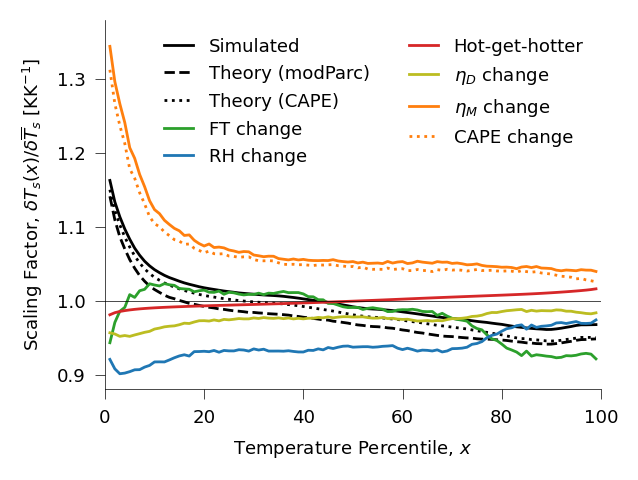

In [158]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)
fig_resize(fig, width['one_col'])
for key in ['', '_sum']:
    ax.plot(ds_sf.quant, np.average(ds_sf[f"scale_factor{key}"], axis=0, weights=lat_weights),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label=style_map[f"scale_factor{key}"][2])
ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[f"scale_factor_sum"], axis=0, weights=lat_weights),
        color=style_map[f"scale_factor_sum"][0],
        label='Theory (CAPE)', linestyle=':')
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        continue
    if np.nanmax(np.average(np.abs(ds_sf[key] - 1), axis=0, weights=lat_weights)) < 0.01:
        continue
    # ax.plot(ds_sf_num.quant, np.average(var, axis=0, weights=lat_weights), label=key,
    #         color=style_map[key][0], linestyle=style_map[key][1])
    ax.plot(ds_sf.quant, np.average(ds_sf[key], axis=0, weights=lat_weights), label=style_map[key][2],
            color=style_map[key][0],
            linestyle=style_map[key][1])
    # # sanity check that all other mechanisms are the same
    # if 'lapse' in key:
    #     continue
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[key], axis=0, weights=lat_weights), color=style_map[key][0],
    #            linestyle=':')
ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape['sCAPE_change'], axis=0, weights=lat_weights),
        color=style_map['sCAPE_change'][0], linestyle=':', label='CAPE change')

update_linewidth(fig)
ax.legend(ncol=2, handlelength=leg_handlelength)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig, 6.5)
ax.set_xlim(0, 100)
ax.set_ylim(0.88, 1.38)
# ax[0].legend(ncol=2)
plt.show()
# savefig(fig)

### Deviation from simulated and theoretical estimates
Why do the simulated and theoretical scaling factors differ?
Below, we split it up into neglecting terms in sum of individual mechanisms, and neglecting non-linear combination of mechanisms.

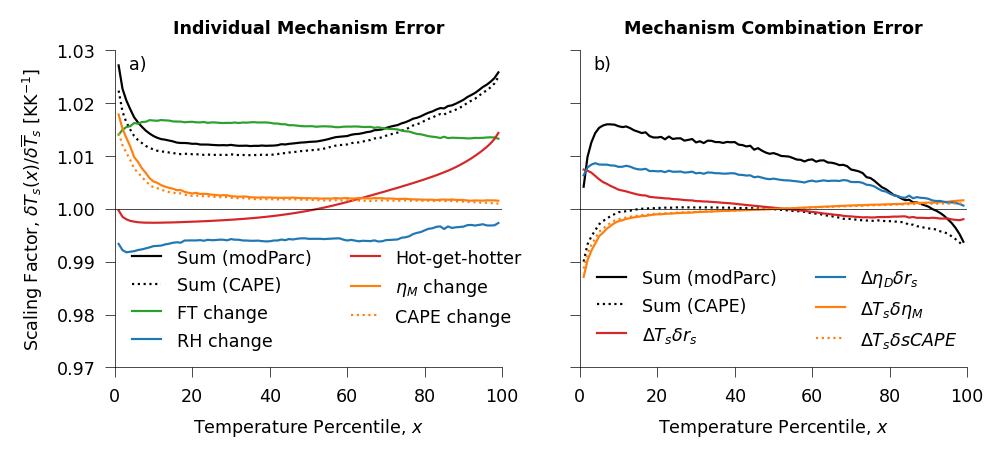

In [159]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold')
ax[1].set_title('Mechanism Combination Error', fontweight='bold')
ax[0].plot(ds_sf_num.quant,
           np.average(ds_sf_num['scale_factor_linear'] - ds_sf['scale_factor_sum'] + 1, axis=0, weights=lat_weights),
           color='k', label='Sum (modParc)')
ax[0].plot(ds_sf_num.quant,
           np.average(ds_sf_num_cape['scale_factor_linear'] - ds_sf_cape['scale_factor_sum'] + 1, axis=0,
                      weights=lat_weights),
           color='k', linestyle=':', label='Sum (CAPE)')

ax[1].plot(ds_sf_num_cape.quant, np.average(ds_sf_num['nl_sum'], axis=0, weights=lat_weights),
           color='k', linestyle='-', label='Sum (modParc)')
ax[1].plot(ds_sf_num_cape.quant, np.average(ds_sf_num_cape['nl_sum'], axis=0, weights=lat_weights),
           color='k', linestyle=':', label='Sum (CAPE)')

# Plot individual mechanism error
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.average(np.abs(ds_sf[key] - 1), axis=0, weights=lat_weights)) < 0.007:
        continue
    if np.nanmax(np.average(np.abs(ds_sf_num[key] - 1), axis=0, weights=lat_weights)) > 0.007:
        ax[0].plot(ds_sf.quant, np.average(ds_sf_num[key], axis=0, weights=lat_weights), label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key):
        continue
    if np.nanmax(np.average(np.abs(ds_sf_num[key] - 1), axis=0, weights=lat_weights)) > 0.007:
        ax[1].plot(ds_sf.quant, np.average(ds_sf_num[key], axis=0, weights=lat_weights), label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])

# Add the CAPE plots
key = 'sCAPE_change'
ax[0].plot(ds_sf_num_cape.quant, np.average(ds_sf_num_cape[key], axis=0, weights=lat_weights), label=style_map[key][2],
           color=style_map[key][0],
           linestyle=style_map[key][1])
key = 'nl_temp_surf_anom_sCAPE_change'
ax[1].plot(ds_sf_num_cape.quant,
           np.average(ds_sf_num_cape['nl_temp_surf_anom_sCAPE_change'], axis=0, weights=lat_weights),
           label=style_map[key][2], color=style_map[key][0], linestyle=style_map[key][1])

update_linewidth(fig)

# Reorder ax1 legend
handles, labels = ax[1].get_legend_handles_labels()
order = [0, 1, 2, 4, 3, 5]  # desired new order by index
ax[1].legend([handles[i] for i in order],
             [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)

ax[0].legend(ncol=2, handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig)
ax[0].set_ylim(0.97, 1.03)
plt.show()
# savefig(fig)

## Lapse rate values
Show values of the lapse rate parameters, and also include daily max data for comparison, and to comment about dry lapse rate.

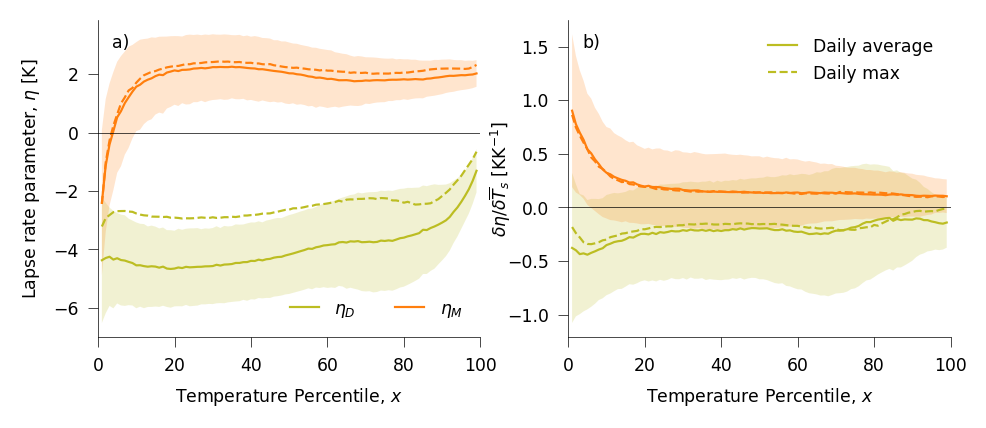

In [160]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)
fig_resize(fig, width['two_col'])
for i, key in enumerate(['lapse_D', 'lapse_M']):
    ax[0].plot(ds_sf.quant, np.average(ds_quant[key].isel(tau_lw=0), axis=1, weights=lat_weights),
               color=style_map[f'{key}_change'][0], label=['$\eta_D$', '$\eta_M$'][i])
    ax[0].fill_between(ds_sf.quant,
                       np.average((ds_quant[key] - ds_quant[f"{key}_std"]).isel(tau_lw=0), axis=1, weights=lat_weights),
                       np.average((ds_quant[key] + ds_quant[f"{key}_std"]).isel(tau_lw=0), axis=1, weights=lat_weights),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")
    var = ds_quant[key].diff(dim='tau_lw').squeeze() / ds_ref.TREFHT.diff(dim='tau_lw').squeeze()
    ax[1].plot(ds_sf.quant, np.average(var, axis=1, weights=lat_weights), color=style_map[f'{key}_change'][0],
               label='Daily average' if i == 0 else None)
    std_diff = np.sqrt(ds_quant[f"{key}_std"].isel(tau_lw=0) ** 2 + ds_quant[f"{key}_std"].isel(tau_lw=1) ** 2
                       ) / ds_ref.TREFHT.diff(dim='tau_lw').squeeze()
    ax[1].fill_between(ds_sf.quant,
                       np.average(var - std_diff, axis=1, weights=lat_weights),
                       np.average(var + std_diff, axis=1, weights=lat_weights),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")

    ax[0].plot(ds_sf.quant, np.average(ds_quant_daily_max[key].isel(tau_lw=0), axis=1, weights=lat_weights),
               color=style_map[f'{key}_change'][0], linestyle='--')
    ax[1].plot(ds_sf.quant, np.average(
        ds_quant_daily_max[key].diff(dim='tau_lw').squeeze() / ds_ref_daily_max.TREFHT.diff(dim='tau_lw').squeeze(),
        axis=1, weights=lat_weights),
               color=style_map[f'{key}_change'][0], linestyle='--', label='Daily max' if i == 0 else None)
update_linewidth(fig)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend(handlelength=leg_handlelength, ncol=2, loc='lower right')
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, box_alpha=0)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel('Lapse rate parameter, $\eta$ [K]')
ax[1].set_ylabel('$\delta \eta/ \delta \overline{T}_s$ [KK$^{-1}$]', labelpad=-2)
fig.subplots_adjust(wspace=0.23)
update_fontsize(fig)
plt.show()
# savefig(fig)